In [2]:
import astropy
from astropy.table import Table
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from bayesn import SEDmodel
import pandas as pd
import jax.random as jr
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import sncosmo
import emcee
import nestle
import corner
print(np.__version__)
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord

/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.26.4


In [1]:
pwd

'/global/u2/r/rayliang/LSST_GLSNe/glsne_dc'

In [5]:
from dustmaps.sfd import SFDQuery

In [ ]:
import os
from dustmaps.config import config
import dustmaps.sfd

dustmaps.sfd.fetch()
dust_data_path = os.path.expanduser('~/dust_data')
config['data_dir'] = dust_data_path

print(f"Dustmaps data directory set to: {config['data_dir']}")


from dustmaps.sfd import SFDQuery
print("Attempting to download SFD98 data...")
sfd = SFDQuery()
print("SFD98 data download complete (or already present).")

In [3]:
head_table = Table(fits.open(f"/global/cfs/cdirs/lsst/www/jolteon/data/FINAL2/JOLTEON_FINAL_0000_HEAD.FITS")[1].data)
phot_table = Table(fits.open(f"/global/cfs/cdirs/lsst/www/jolteon/data/FINAL2/JOLTEON_FINAL_0000_PHOT.FITS")[1].data)
#read in the dables

print("HEAD columns:", head_table.colnames)
print("PHOT columns:", phot_table.colnames)

#SNIa_mask = "SNIa" in head_table['LABEL'] 
#head_table = head_table[SNIa_mask]
#phot_table = phot_table[SNIa_mask]


HEAD columns: ['SNID', 'RA', 'DEC', 'MWEBV', 'MWEBV_ERR', 'SPECZ', 'SPECZ_ERR', 'PHOTOZ', 'PHOTOZ_ERR', 'NOBS', 'MJD_DETECT_FIRST', 'MJD_DETECT_LAST', 'PTROBS_MIN', 'PTROBS_MAX', 'LABEL']
PHOT columns: ['MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR', 'SKY_SIG', 'PSF', 'ZEROPT', 'SIM_MAGOBS']


100002 SNII+HostXT_V19


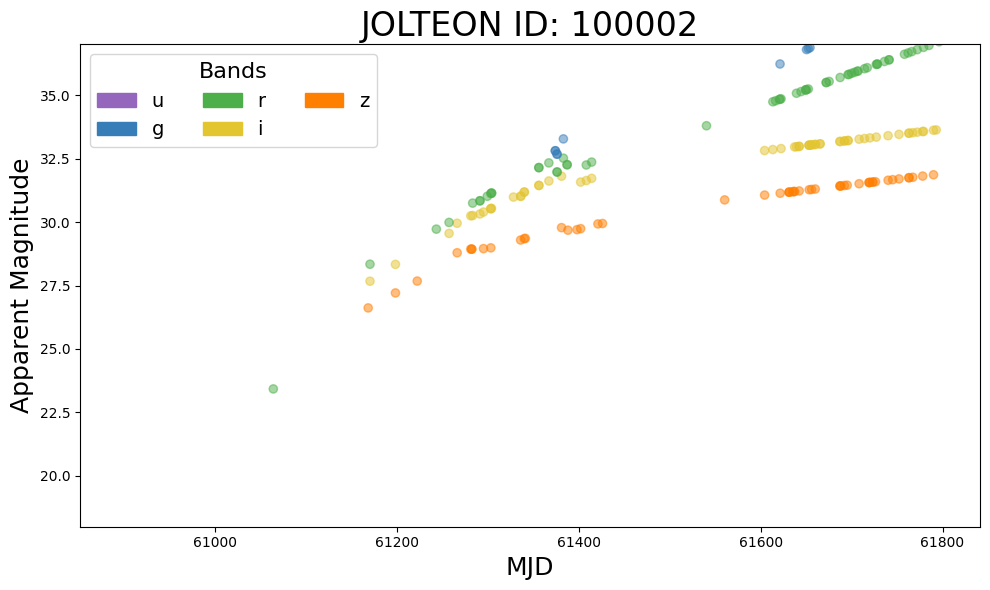

In [4]:
sn_results = []  #SNID, z, peak_mag, type, etc.
idx = 1 #673, 0, 4567, 2059, 1573, 3987, 4968, 4970, 137;   101, 139, 501, 4766
snid = head_table[idx]['SNID']
z = head_table[idx]['PHOTOZ']
ptr_min = head_table[idx]['PTROBS_MIN']
ptr_max = head_table[idx]['PTROBS_MAX']
lc = phot_table[ptr_min-1:ptr_max]
#read in all the data

#define colour dictionary for plots
colors = {'u': '#9467bd', 'g': '#377eb8', 'r': '#4daf4a', 'i': '#e3c530', 'z': '#ff7f00'}
markers = {0: 'o', 1: '^'}

print(head_table[idx]['SNID'], head_table[idx]['LABEL']) #print SN ID and Type

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.scatter(lc['MJD'], lc['SIM_MAGOBS'], c=[colors[band] for band in lc['BAND']], alpha = 0.5)
ax.set_ylim(37,18)

#create legend patches
legend_patches = [mpatches.Patch(color=color, label=band.strip()) for band, color in colors.items()]

#add legend
ax.legend(handles=legend_patches, title="Bands", fontsize=14, title_fontsize=16, ncol=3)
plt.gca().invert_yaxis()
ax.set_xlabel("MJD", fontsize=18)
ax.set_ylabel("Apparent Magnitude", fontsize=18)
ax.set_title(f'JOLTEON ID: {head_table[idx]["SNID"]}', fontsize=24)
fig.tight_layout()
fig.show()

In [9]:
#extract & sort all the data

filt_map_s = {'g': 'lsstg','r': 'lsstr','i': 'lssti','z': 'lsstz', 'u': 'lsstu'} #for sncosmo
lcs = lc.to_pandas() #check if already a dataframe
mapped_filt_s = [filt_map_s.get(f, f) for f in lcs['BAND']]
lcs['BAND'] = mapped_filt_s

#lc = lc[lc["BAND"] != "lsstu"]
lcs = lcs[lcs['FLUXCAL'] > 0]
lcs = lcs[lcs['FLUXCALERR'] > 0]
lcs['m'] = -2.5 * np.log10(lcs['FLUXCAL']) + 27.5
lcs['dm'] = np.abs(-2.5 * lcs['FLUXCALERR'] / (np.log(10) * lcs['FLUXCAL']))
lcs = lcs.dropna(subset=['m', 'dm', 'BAND'])
#calculate the magnitudes and write them to lc; 
#drop the nan's to avoid error
print(lcs)

mask_s = np.isfinite(lcs['m']) & np.isfinite(lcs['dm']) & (lcs['BAND'] != '')
lcs = lcs[mask_s]
print(lcs['BAND'].unique())

peak_mjd_s = lcs['MJD'].iloc[lcs['SIM_MAGOBS'].argmin()]
relative_mjd_s = lcs['MJD'] - peak_mjd_s
time_window_mask_s = (relative_mjd_s >= -20) & (relative_mjd_s <= 50)
lcs = lcs[time_window_mask_s]
print(lcs['BAND'].unique())
print(peak_mjd_s)


filt_map_b = {'g': 'g_LSST', 'r': 'r_LSST', 'i': 'i_LSST', 'z': 'z_LSST', 'u': 'u_LSST'} #for bayesn
lcb = lc.to_pandas()
mapped_filt_b = [filt_map_b.get(f, f) for f in lcb['BAND']]
lcb['BAND'] = mapped_filt_b

lcb = lcb[lcb['FLUXCAL'] > 0]
lcb = lcb[lcb['FLUXCALERR'] > 0]
lcb['m'] = -2.5 * np.log10(lcb['FLUXCAL']) + 27.5
lcb['dm'] = np.abs(-2.5 * lcb['FLUXCALERR'] / (np.log(10) * lcb['FLUXCAL']))
lcb = lcb.dropna(subset=['m', 'dm', 'BAND'])

mask_b = np.isfinite(lcb['m']) & np.isfinite(lcb['dm']) & (lcb['BAND'] != '')
lcb = lcb[mask_b]
print(lcb['BAND'].unique())

#peak_mjd_b = lcb['MJD'].iloc[lcb['FLUXCAL'].argmax()]
peak_mjd_b = lcb['MJD'].iloc[lcb['SIM_MAGOBS'].argmin()]
relative_mjd_b = lcb['MJD'] - peak_mjd_b
time_window_mask_b = (relative_mjd_b >= -20) & (relative_mjd_b <= 50)
lcb = lcb[time_window_mask_b]
print(lcb['BAND'].unique())
print(peak_mjd_b)
model_b = SEDmodel(load_model='BAYESN_1.YAML')

#print(5*np.log10(738.6 * 1e6) - 5)
#print(head_table[idx]['MWEBV'])

ra = head_table[idx]['RA']
dec = head_table[idx]['DEC']

coords_sn = SkyCoord(ra * u.deg, dec * u.deg, frame='icrs')
sfd_query = SFDQuery() # Instantiate the query object (do this once if processing many)
mw_ebv = sfd_query(coords_sn)

            MJD   BAND    FLUXCAL  FLUXCALERR    SKY_SIG       PSF  ZEROPT  \
2    61847.9994  lsstz  66.563457   34.279775  50.095186  2.205352    27.5   
4    61844.0061  lsstz  13.249152   28.713689  41.285989  2.246496    27.5   
6    61843.9999  lsstz   5.524560   41.563352  59.473721  2.322798    27.5   
7    61843.9968  lsstz  22.708791   50.026360  75.922434  2.220626    27.5   
10   61798.0910  lssti   1.669389    6.956522  33.745728  1.841828    27.5   
..          ...    ...        ...         ...        ...       ...     ...   
218  60939.2470  lssti   4.162316    4.627896  30.524576  1.417674    27.5   
222  60933.2603  lssti   0.370565    8.655275  30.046376  2.671125    27.5   
224  60932.3861  lssti  23.141748    9.135364  34.908647  2.479161    27.5   
225  60930.4027  lsstz   1.532808   15.645133  50.796983  2.181039    27.5   
227  60915.4179  lsstz   9.648072   12.394044  51.161973  1.730450    27.5   

     SIM_MAGOBS          m         dm  
2     99.000000  22.941

In [ ]:
#sncosmo version

lcs = lcs.rename(columns={'FLUXCAL': 'FLUX', 'FLUXCALERR': 'FLUXERR'})  #rename the columns so sncosmo knows what im doing
lcs = Table.from_pandas(lcs)   #convert pandas dataframe into astropy Table that sncosmo requires; "s" for sncosmo

new_column_values = ["ab"] * len(lcs)   #add magnitude system so sncosmo knows what im doing
lcs['zpsys'] = new_column_values        #only works after lc has been converted into an astropy Table

model = sncosmo.Model(source='salt3', effects=[sncosmo.OD94Dust()], effect_names=['mw'], effect_frames=['obs'])
model.set(z=z)
model.set(t0=peak_mjd_s)


result, fitted_model = sncosmo.nest_lc(lcs, model,['x0', 'x1', 'c'], fixed={'mw_ebv': mw_ebv, 'mw_rv': 3.1}, guess_ampitude_bound=True, bounds={'x1':(0.5, 2.2), 
                        'c':(-0.4, 0.6),'x0':(-0.003, 0.003)}, guess_z=False, minsnr=0, guess_t0=False)   
#result, fitted_model = sncosmo.nest_lc(lcs, model,['x0', 'x1', 'c'], guess_ampitude_bound=True, bounds={'x1':(0, 1), 
#                        'c':(0.0, 0.5),'x0':(0, 0.002)}, guess_z=False, minsnr=0, guess_t0=False)    

fig = corner.corner(result.samples, labels=result.vparam_names,sample_weight=result.weights)
plt.show()

In [ ]:
###sncosmo version plotting
sncosmo.plot_lc(lcs, model=fitted_model, errors=result.errors)
plt.show()


offsets = [0,0,0,0,0]
filters = ['lsstg', 'lsstr', 'lssti', 'lsstz', 'lsstu']

fig=plt.figure(figsize=(8,6))
plt.gca().invert_yaxis()
plt.xlabel("MJD")
plt.ylabel("m")
plt.legend()
for i, f in enumerate(filters):  
    sel = (lcs['BAND'] == f)   
    plt.errorbar(lcs['MJD'][sel], lcs['m'][sel], yerr=lcs['dm'][sel], fmt='x', color=colors[f[-1]], label=filters[i])
    t = np.arange(-20, 50, 1)
    plot_t = t + fitted_model['t0']
    offset_value = offsets[i % len(offsets)]
    model_mags = fitted_model.bandmag(f, 'ab', plot_t) + offset_value 
    plt.plot(plot_t, model_mags, color=colors[f[-1]])

plt.show()

In [ ]:
#sncosmo version of find peak magnitude, and therefore observed distance modulus
x0_fit = fitted_model.parameters[fitted_model.param_names.index('x0')]
m_B = -2.5 * np.log10(x0_fit)+10.635-.27
x1_fit = fitted_model.parameters[fitted_model.param_names.index('x1')]
c_fit = fitted_model.parameters[fitted_model.param_names.index('c')]
x0_fit_err = result.errors['x0']
x1_fit_err = result.errors['x1']
c_fit_err = result.errors['c']

alpha = 0.14 #.003
beta = 3.1  #.17
m_std = m_B + (alpha * x1_fit) - (beta * c_fit)
M0 = -19.0
mu_obs_s = m_std - M0
print(mu_obs_s)


def salt2mu(x1=None,x1err=None,
            c=None,cerr=None,
            mb=None,mberr=None, #error of the x0
            cov_x1_c=0,cov_x1_x0=0,cov_c_x0=0,
            alpha=None,beta=None,hostmass=None,
            M=None,x0=None,sigint=None,z=None,peczerr=0.00083,deltam=None):

     sf = -2.5/(x0*np.log(10.0))
     cov_mb_c = cov_c_x0*sf
     cov_mb_x1 = cov_x1_x0*sf
     mu_out = mb + x1*alpha - beta*c + 19.36
     invvars = 1.0 / (mberr**2.+ alpha**2. * x1err**2. + beta**2. * cerr**2. + \
           2.0 * alpha * (cov_x1_x0*sf) - 2.0 * beta * (cov_c_x0*sf) - \
           2.0 * alpha*beta * (cov_x1_c) )

     if deltam:
          if len(np.where(hostmass > 10)[0]):
               mu_out[hostmass > 10] += deltam/2.
          if len(np.where(hostmass < 10)[0]):
               mu_out[hostmass < 10] -= deltam/2.

     zerr = peczerr*5.0/np.log(10)*(1.0+z)/(z*(1.0+z/2.0))
     muerr_out = np.sqrt(1/invvars + zerr**2. + 0.055**2.*z**2.)
     if sigint: muerr_out = np.sqrt(muerr_out**2. + sigint**2.)
     return(mu_out,muerr_out)


mu_obs_s, mu_obs_s_err = salt2mu(x1=x1_fit, x1err=x1_fit_err, c=c_fit, cerr=c_fit_err, mb=m_B, mberr=x0_fit_err, alpha=alpha, beta=beta, M=M0, x0=x0_fit, z=z)
print(mu_obs_s, mu_obs_s_err)


#for param_name in result.vparam_names:
#    param_value = fitted_model.parameters[fitted_model.param_names.index(param_name)]
#    param_error = result.errors[param_name]
#    print(f"{param_name}: {param_value:.4e} +/- {param_error:.4e}")


In [ ]:
#BayeSN version fitting

#model = SEDmodel(load_model='T21_model')
#model_b = SEDmodel(load_model='BAYESN_1.YAML') # see the data processing section

'''
samples, sn_props = model.fit(
        lcb['MJD'], lcb['m'], lcb['dm'], lcb['BAND'],
        z=z, peak_mjd=peak_mjd_b,
        ebv_mw=mw_ebv,
        filt_map=filt_map_b, 
        mag=True)
'''

samples, sn_props = model_b.fit(
        lcb['MJD'], lcb['m'], lcb['dm'], lcb['BAND'],
        z=z, peak_mjd=peak_mjd_b,
        ebv_mw=mw_ebv,
        filt_map=filt_map_b, 
        mag=True)
    

#print(head_table['MWEBV'][idx])
#print(lcb)

In [ ]:
#BayeSN version plotting 
t = np.arange(-20, 50, 1) 
z_b, mw_ebv_b = sn_props
bands = ['u_LSST', 'g_LSST', 'r_LSST', 'i_LSST', 'z_LSST']
plot_t = t + peak_mjd_b

#obtain fit data
flux_grid = model.get_flux_from_chains(t, bands, samples, z_b, [mw_ebv_b],  mag=True, num_samples=1000) 
fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))

for b in bands:   
    b_data = lcb[lcb['BAND'] == b]
    plt.errorbar(b_data.MJD, b_data.m, b_data.dm, fmt='x', color=colors[b[0]], label=b, linestyle='none')    
    b_ind = bands.index(b)
    plt.plot(plot_t, fit[b_ind, :], color=colors[b[0]]) 
    plt.fill_between(plot_t, fit[b_ind, :] - fit_err[b_ind, :], fit[b_ind, :] + fit_err[b_ind, :], alpha=0.3, color=colors[b[0]])

plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('m')
plt.legend()
plt.show()



In [ ]:
mu_obs_b = np.mean(samples['Ds'])

print(mu_obs_b)

In [ ]:
## for finding the expected distance modulus
## same functionality as 5*np.log10(738.6 * 1e6) - 5

H0_value = 73.6
Om0_value = 0.334
cosmo = FlatLambdaCDM(H0=H0_value * u.km / u.s / u.Mpc, Om0=Om0_value)
mu_exp = cosmo.distmod(z)

print(z)
print(mu_exp)
print('sncosmo fit', mu_obs_s - mu_exp.value)
print('bayesn fit', mu_obs_b - mu_exp.value) 

In [ ]:
''' Old function that tried to do all SN in one block of code
DO NOT TOUCH OR USE!!!

filt_map = {'u': 'u_DES', 'g': 'g_DES', 'r': 'r_DES', 'i': 'i_DES', 'z': 'z_DES'} 
#model = SEDmodel(load_model='85_day_model.YAML')
model = SEDmodel(load_model='salt3-nir')

def peak_mag_bayesn(lc, z, filt_map, t_min, t_max, ebv_mw=1/31, bands=['u_DES', 'g_DES', 'r_DES', 'i_DES', 'z_DES'], num_samples=100): 
    df = lc.to_pandas()
    df = df.rename(columns={'FLUXCAL': 'flux_c', 'FLUXCALERR': 'dflux_c', 'BAND': 'filt', 'MJD': 'MJD'})
    df = df.dropna(subset=['MJD', 'flux_c', 'dflux_c', 'filt'])

    df['filt'] = df['filt'].map(filt_map)

    df['m'] = -2.5 * np.log10(df['flux_c']) + 27.5
    df['dm'] = np.abs(-2.5 * df['dflux_c'] / (np.log(10) * df['flux_c']))
    df = df.dropna(subset=['m', 'dm'])
    peak_mjd = df['MJD'].iloc[df['m'].argmin()]
    t_min = peak_mjd - 10
    t_max = peak_mjd + 10

    samples, sn_props = model.fit(
        df['MJD'], df['m'], df['dm'], df['filt'],
        z=z, peak_mjd=peak_mjd,
        ebv_mw=ebv_mw,
        filt_map=filt_map,
        mag=True
    )
    

    #mag_list = []
    peak_mag_list = []
    t = np.arange(t_min, t_max, 1)
    z, ebv_mw = sn_props

    
    flux_grid = model.get_flux_from_chains(t, bands, samples, z, ebv_mw, mag=True, num_samples=num_samples)
    fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))
    for b_ind, b in enumerate(bands):
        mag_list.append(fit[b_ind, :])
        peak_mag_list.append(np.max(fit[b_ind, :]))

    #return peak_mag
    return mag_list, peak_mag_list #in order of bands
    

sn_results = []  #SNID, z, peak_mag, type, etc.
snid_list = []
z_list = []
lc_list = []
ptr_min_list = []
ptr_max_list = []
for idx in range(len(head_table)):    
    snid_list.append(head_table[idx]['SNID'])
    z_list.append(head_table[idx]['SPECZ']) 
    ptr_min_list.append(head_table[idx]['PTROBS_MIN'])
    ptr_max_list.append(head_table[idx]['PTROBS_MAX'])
    lc_list.append(phot_table[ptr_min_list[idx]-1:ptr_max_list[idx]])


fails = 0
for i in range(len(head_table)):
    try:
        mag, peak_mag = peak_mag_bayesn(lc_list[i], z_list[i], filt_map, ptr_min_list[i], ptr_max_list[i])
        #peak_mag = peak_mag_bayesn(lc_list[i], z_list[i], filt_map, ptr_min_list[i], ptr_max_list[i])
    except Exception as e:
        print(f"Fit failed for SNID {snid_list[i]}: {e}")
        fails += 1
        continue
 
    sn_results.append({
        "SNID": snid_list[i],
        "redshift": float(z_list[i]),
        "peak_mag": float(np.max(peak_mag)) if peak_mag is not None else None, #find peak mags of all the bands
        #"peak_mag": peak_mag
    })

print("Failed fits: ", fails, "/", len(snid_list))
plt.hist([r['peak_mag'] for r in sn_results if r['peak_mag'] is not None], bins=30)
plt.xlabel('Peak magnitude')
plt.ylabel('Number of SNe')
plt.show()
'''

In [ ]:
sn_results = []  #SNID, z, peak_mag, type, etc.
snid_list = []
z_list = []
lc_list = []
ptr_min_list = []
ptr_max_list = []
for idx in range(len(head_table)):    
    snid_list.append(head_table[idx]['SNID'])
    z_list.append(head_table[idx]['SPECZ']) 
    ptr_min_list.append(head_table[idx]['PTROBS_MIN'])
    ptr_max_list.append(head_table[idx]['PTROBS_MAX'])
    lc_list.append(phot_table[ptr_min_list[idx]-1:ptr_max_list[idx]])

In [ ]:
a = 100
print(np.max(lc_list[a]['MJD']) - np.min(lc_list[a]['MJD']))
print(ptr_max_list[a] - ptr_min_list[a])

In [ ]:
bin_width = 0.05
binned_peaks = {}

for result in sn_results:
    z = result["redshift"]

    bin_index = int(z / bin_width) 
    bin_z_lower = bin_index * bin_width 
    if result["peak_mag"] is not None:
        binned_peaks.setdefault(bin_z_lower, []).append(result["peak_mag"])

def check_bin(example_bins = [0.0, 0.25, 0.5, 1.0]):
    for b in example_bins:
        if b in binned_peaks:
            print(f"Bin z=[{b:.2f}, {b+bin_width:.2f}): {len(binned_peaks[b])} SNe")
    return example_bins

print(check_bin())

In [ ]:
bin_median_peak = {}
for bin_z, peak_list in binned_peaks.items():
    if len(peak_list) == 0:
        continue
    median_mag = float(np.median(peak_list))
    bin_median_peak[bin_z] = median_mag
    

def check_median(n=5):
    for b in sorted(bin_median_peak)[:n]: 
        print(f"Bin starting {b:.2f}: median peak mag = {bin_median_peak[b]:.2f}")
    return n

In [ ]:
lensed_candidates = []
mag_threshold = 1.5 #ab mags

for result in sn_results:
    m_peak = result["peak_mag"]
    z = result["redshift"]
    if m_peak is None or z is None:
        continue  
    bin_index = int(z / bin_width)
    bin_z_lower = bin_index * bin_width
    if bin_z_lower not in bin_median_peak:
        continue  
    median_mag = bin_median_peak[bin_z_lower]
   
    if m_peak < median_mag - mag_threshold:
        diff = median_mag - m_peak
        candidate_info = {
            "SNID": result["SNID"],
            "redshift": result["redshift"],
            "peak_mag": result["peak_mag"],
            "type": result["type"],
            "mag_diff": diff
        }
        lensed_candidates.append(candidate_info)

In [ ]:
if candidates:
    for c in candidates:
        snid = c["SNID"]
        z = c["redshift"]
        peak = c["peak_mag"]
        mag_excess = c["mag_diff"]  #how much brighter than median
        sn_type = c.get("type", None)

        type_str = f"Type={sn_type}" if sn_type is not None else "Type=Unknown"
        print(f"SNID {snid}: z={z:.3f}, PeakMag={peak:.2f}, {type_str}, Δm={mag_excess:.2f} mag brighter than median")
